<a href="https://colab.research.google.com/github/ipremodi/Stress-Detection-/blob/main/ProjectWESAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT : WESAD

## Importing Libraries

In [4]:
# 1. Force install stable PyTorch compatible with Colab
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# 2. Install Graph Neural Network libraries (Pre-built for speed)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html

# 3. Install PyTorch Geometric
!pip install torch-geometric

import torch
print(f"Setup Complete! Using GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

Looking in indexes: https://download.pytorch.org/whl/cu124
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Setup Complete! Using GPU: Tesla T4


In [5]:
import os
import zipfile

# 1. Download the WESAD dataset (Directly from Uni-Siegen servers)
print("Downloading WESAD dataset (approx. 2.5GB)... this takes 1-2 mins on Colab.")
!wget -O WESAD.zip "https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download"

# 2. Unzip only the S2.pkl file (Subject 2) to save space
print("Extracting Subject 2 data...")
with zipfile.ZipFile("WESAD.zip", "r") as z:
    # Extract S2.pkl specifically
    z.extract("WESAD/S2/S2.pkl", path="/content/")

# 3. Move it to the main folder for easy access
!mv /content/WESAD/S2/S2.pkl /content/S2.pkl

# 4. Clean up the zip file to save space
!rm WESAD.zip
print("Done! Real data is ready at: /content/S2.pkl")

--2025-12-14 11:28:14--  https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download
Resolving uni-siegen.sciebo.de (uni-siegen.sciebo.de)... 128.176.1.4
Connecting to uni-siegen.sciebo.de (uni-siegen.sciebo.de)|128.176.1.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2249444501 (2.1G) [application/zip]
Saving to: ‘WESAD.zip’

WESAD.zip           100%[===================>]   2.09G  25.9MB/s    in 84s     

2025-12-14 11:29:39 (25.5 MB/s) - ‘WESAD.zip’ saved [2249444501/2249444501]

Extracting Subject 2 data...
Done! Real data is ready at: /content/S2.pkl


In [6]:
# Use the real dataset path we just created
file_path = '/content/S2.pkl'

In [7]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch_geometric.nn import ChebConv
import math
import matplotlib.pyplot as plt
from torch_geometric.utils import softmax

In [8]:
# Load your data
file_path = 'S2.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')


In [9]:
data['label'][data['label'] == 7] = 5 # Replacing label 7 with 5 (since original label 5 was previously replaced with 7)

## Reading Data

In [10]:
def extract_chest_data(data):
    """
    Extracts and flattens individual chest sensor signals from a given dictionary
    containing wearable sensor data. The extracted signals include 3-axis
    accelerometer, ECG, EMG, EDA, temperature, and respiration.

    Parameters:
    - data (dict): Dictionary containing keys like 'ACC', 'ECG', 'EMG', etc., each
                   associated with a NumPy array of signal readings.

    Returns:
    - df_new (DataFrame): A pandas DataFrame with each signal as a separate column.
    """
    Chest_acc_X = data['ACC'][:,0].flatten()  # X-axis of chest accelerometer
    Chest_acc_Y = data['ACC'][:,1].flatten()  # Y-axis of chest accelerometer
    Chest_acc_Z = data['ACC'][:,2].flatten()  # Z-axis of chest accelerometer

    Chest_ECG = data['ECG'].flatten()         # ECG signal
    Chest_EMG = data['EMG'].flatten()         # EMG signal
    Chest_EDA = data['EDA'].flatten()         # Electrodermal activity
    Chest_Temp = data['Temp'].flatten()       # Temperature signal
    Chest_Resp = data['Resp'].flatten()       # Respiration signal

    # Combine all extracted signals into a single DataFrame
    df_new = pd.DataFrame({
        'Chest Acc X': Chest_acc_X,
        'Chest Acc Y': Chest_acc_Y,
        'Chest Acc Z': Chest_acc_Z,
        'Chest ECG': Chest_ECG,
        'Chest EMG': Chest_EMG,
        'Chest EDA': Chest_EDA,
        'Chest Temp': Chest_Temp,
        'Chest Resp': Chest_Resp
    })
    return df_new


def expand_signal_with_nans(signal, original_freq, target_freq):
    """
    Upsamples a lower-frequency signal to a higher target frequency by inserting NaNs.
    This allows signals of varying sampling rates to align in a unified high-frequency
    time series (e.g., 700Hz).

    Parameters:
    - signal (np.array): Original signal array to expand.
    - original_freq (int): Original sampling frequency of the signal.
    - target_freq (int): Target frequency to expand to.

    Returns:
    - np.array: Expanded signal with NaNs inserted.
    """
    expand_factor = round(target_freq / original_freq)  # Number of points to insert between samples
    expanded = []
    counter = 0

    for value in signal:
        expanded.append(value)
        expanded.extend([np.nan] * (expand_factor - 1))  # Insert NaNs

        counter += 1

        # Adjustment step: for specific frequencies, trim 4 samples every 1 second worth of data
        if (original_freq == 32 and counter == 32) or (original_freq == 64 and counter == 64):
            del expanded[-4:]  # Remove 4 last samples (usually NaNs)
            counter = 0

    return np.array(expanded)


def extract_wrist_data(data):
    """
    Extracts and up-samples wrist sensor data to 700Hz by inserting NaNs between original samples.
    This prepares all wrist signals to match the unified sampling frequency used in model training.

    Parameters:
    - data (dict): Dictionary containing wrist sensor arrays for ACC, BVP, EDA, and TEMP.

    Returns:
    - df_new (DataFrame): A pandas DataFrame with expanded wrist signals as columns.
    """
    Wrist_acc_X = data['ACC'][:,0].flatten()  # X-axis wrist accelerometer
    Wrist_acc_Y = data['ACC'][:,1].flatten()  # Y-axis wrist accelerometer
    Wrist_acc_Z = data['ACC'][:,2].flatten()  # Z-axis wrist accelerometer

    Wrist_BVP = data['BVP'].flatten()         # Blood volume pulse
    Wrist_EDA = data['EDA'].flatten()         # Electrodermal activity
    Wrist_TEMP = data['TEMP'].flatten()       # Temperature

    # Expand all signals to 700Hz by inserting NaNs
    Wrist_acc_X_expanded = expand_signal_with_nans(Wrist_acc_X, original_freq=32, target_freq=700)
    Wrist_acc_Y_expanded = expand_signal_with_nans(Wrist_acc_Y, original_freq=32, target_freq=700)
    Wrist_acc_Z_expanded = expand_signal_with_nans(Wrist_acc_Z, original_freq=32, target_freq=700)

    Wrist_BVP_expanded = expand_signal_with_nans(Wrist_BVP, original_freq=64, target_freq=700)
    Wrist_EDA_expanded = expand_signal_with_nans(Wrist_EDA, original_freq=4, target_freq=700)
    Wrist_TEMP_expanded = expand_signal_with_nans(Wrist_TEMP, original_freq=4, target_freq=700)

    # Combine expanded signals into a DataFrame
    df_new = pd.DataFrame({
        'Wrist Acc X': Wrist_acc_X_expanded,
        'Wrist Acc Y': Wrist_acc_Y_expanded,
        'Wrist Acc Z': Wrist_acc_Z_expanded,
        'Wrist BVP': Wrist_BVP_expanded,
        'Wrist EDA': Wrist_EDA_expanded,
        'Wrist Temp': Wrist_TEMP_expanded
    })
    return df_new


In [11]:
# Extract chest and wrist sensor data as DataFrames from the nested dictionary
chest_df = extract_chest_data(data['signal']['chest'])
wrist_df = extract_wrist_data(data['signal']['wrist'])

# Align the lengths of chest and wrist DataFrames by truncating both
min_len = min(len(chest_df), len(wrist_df))
chest_df = chest_df.iloc[:min_len]  # Truncate chest data
wrist_df = wrist_df.iloc[:min_len]  # Truncate wrist data

# Merge the truncated chest and wrist DataFrames column-wise
combined_df = pd.concat([chest_df.reset_index(drop=True), wrist_df.reset_index(drop=True)], axis=1)

# Convert the merged DataFrame to a NumPy array of float32 for further processing (e.g., feeding into models)
features = combined_df.to_numpy(dtype=np.float32)
# Fill NaNs with 0
features_clean = np.nan_to_num(features, nan=0.0)

In [12]:
# Convert cleaned feature matrix to PyTorch tensor (float32)
x = torch.tensor(features_clean, dtype=torch.float)

# Convert labels to a PyTorch tensor (int64/long) and ensure they match the feature length
y = torch.tensor(data['label'][:min_len], dtype=torch.long)

# Define the different experimental phases with their start and end times in minutes
phases = {
    'Base':  (7.08, 26.32),
    'TSST':  (39.55, 50.30),
    'Medi1': (70.19, 77.10),
    'Fun':   (81.25, 87.47),
    'Medi2': (93.38, 100.15),
    'sRead': (54.42, 56.07),
    'fRead': (89.51, 91.15)
}

fs = 700  # Sampling frequency in Hz

# Build edges by connecting sequential time points (nodes) within each defined phase
edges = []
for phase, (start_min, end_min) in phases.items():
    start_idx = int(start_min * 60 * fs)  # Convert minutes to sample index
    end_idx = int(end_min * 60 * fs)

    for i in range(start_idx, end_idx - 1):
        edges.append((i, i + 1))    # Forward edge
        edges.append((i + 1, i))    # Backward edge (undirected graph)

# Convert edge list to PyTorch tensor of shape [2, num_edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

from sklearn.model_selection import train_test_split
import torch
import numpy as np

def create_node_masks(num_nodes, train_ratio=0.8):
    """
    Randomly splits the nodes into training and testing sets.

    Args:
        num_nodes (int): Total number of nodes in the graph.
        train_ratio (float): Fraction of nodes to include in the training set (default: 0.8).

    Returns:
        train_mask (torch.BoolTensor): Boolean mask indicating training nodes.
        test_mask (torch.BoolTensor): Boolean mask indicating testing nodes.
    """
    indices = np.arange(num_nodes)  # Generate sequential indices for all nodes

    # Perform a random split into train and test indices
    train_idx, test_idx = train_test_split(indices, train_size=train_ratio, shuffle=True)

    # Initialize boolean masks for train/test
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Set corresponding indices to True
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    return train_mask, test_mask

# Get total number of nodes in the graph
num_nodes = x.shape[0]

# Create train and test node masks
train_node_mask, test_node_mask = create_node_masks(num_nodes)

# Determine the total number of time points (used later for sequence-based models)
max_len = len(x)

# Create the final graph data object for PyTorch Geometric
graph_data = Data(
    x=x,                        # Node features
    edge_index=edge_index,     # Edges between nodes
    y=y,                        # Labels
    train_mask=train_node_mask,  # Training mask
    test_mask=test_node_mask     # Testing mask
)


In [13]:
graph_data

Data(x=[4255300, 14], edge_index=[2, 4467110], y=[4255300], train_mask=[4255300], test_mask=[4255300])

In [14]:
x = graph_data.x.cpu().numpy()
x = StandardScaler().fit_transform(x)
graph_data.x = torch.tensor(x, dtype=torch.float)

In [15]:
def evaluate_f1(model, data, mask,out):
    """
    Evaluate the model's performance using accuracy and F1 scores.

    Args:
        model (nn.Module): The trained GNN model to evaluate.
        data (Data): A PyTorch Geometric data object containing graph information
                     (x: node features, edge_index: edges, edge_attr: edge features, y: labels).
        mask (BoolTensor): A boolean mask indicating which nodes/edges to evaluate
                           (e.g., train/validation/test split).

    Returns:
        tuple:
            - accuracy (float): Classification accuracy on the masked data.
            - f1_macro (float): Macro-averaged F1 score (treats all classes equally).
            - f1_weighted (float): Weighted-averaged F1 score (accounts for class imbalance).
    """

    model.eval()  # Set model to evaluation mode (deactivates dropout, etc.)

    with torch.no_grad():  # No gradients needed during evaluation
        # Forward pass to get model outputs


        # Get predicted class labels
        pred = out.argmax(dim=-1)

        # Extract the true labels and predicted labels for the given mask
        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        # Simple accuracy
        f1_macro = f1_score(y_true, y_pred, average='macro')   # F1 score treating all classes equally
        f1_weighted = f1_score(y_true, y_pred, average='weighted')  # F1 score weighted by support (class size)

        return acc, f1_macro, f1_weighted

# MedGCN

In [16]:
class GraphSRMLayer(nn.Module):
    """
    GraphSRMLayer implements the Selective Recalibration Module (SRM) for graphs.

    It adaptively recalibrates feature-wise responses by learning gates
    based on global mean and standard deviation across all nodes.

    Args:
        channels (int): Number of input feature channels.
    """
    def __init__(self, channels):
        super(GraphSRMLayer, self).__init__()
        self.cfc = nn.Parameter(torch.Tensor(2, 1))  # Feature fusion weights for mean and std
        self.ln = nn.LayerNorm(channels)  # Layer normalization for recalibrated feature vector
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize fusion weights using Kaiming initialization
        nn.init.kaiming_uniform_(self.cfc, a=math.sqrt(5))

    def forward(self, x):
        """
        Forward pass of GraphSRMLayer.

        Args:
            x (Tensor): Node features of shape (num_nodes, num_features)

        Returns:
            Tensor: Feature-wise gated node features of the same shape.
        """
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True)
        stats = torch.cat((mean, std), dim=0).T  # Shape: (features, 2)
        gates = torch.matmul(stats, self.cfc).squeeze(-1)  # Shape: (features,)
        gates = self.ln(gates)  # Normalize feature gates
        gates = torch.sigmoid(gates).unsqueeze(0)  # Shape: (1, features)
        return x * gates  # Recalibrate features


class MedGCN(nn.Module):
    """
    MedGCN model using ChebConv and SRM for node classification.

    It integrates a global feature recalibration (SRM) and multi-layer Chebyshev Graph Convolutions.

    Args:
        in_channels (int): Number of input node features.
        hidden_channels (int): Number of hidden units in intermediate layers.
        out_channels (int): Number of output classes.
        K (int): Chebyshev polynomial order for spectral convolution.
        dropout (float): Dropout rate.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, K=3, dropout=0.5):
        super(MedGCN, self).__init__()
        self.srm = GraphSRMLayer(channels=in_channels)

        self.conv1 = ChebConv(in_channels, hidden_channels, K)
        self.ln1 = nn.LayerNorm(hidden_channels)

        self.conv2 = ChebConv(hidden_channels, hidden_channels, K)
        self.ln2 = nn.LayerNorm(hidden_channels)

        self.conv3 = ChebConv(hidden_channels, out_channels, K)
        self.dropout = dropout

    def forward(self, data):
        """
        Forward pass of the MedGCN model.

        Args:
            data (Data): PyG graph data object.

        Returns:
            Tensor: Logits of shape (num_nodes, out_channels)
        """
        x, edge_index = data.x, data.edge_index
        x = self.srm(x)

        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return x


def train_medgcn(model, data, optimizer, criterion):
    """
    One training step for MedGCN.

    Args:
        model (MedGCN): The MedGCN model.
        data (Data): PyG Data object with graph.
        optimizer (Optimizer): Optimizer for updating parameters.
        criterion (Loss): Loss function (e.g., CrossEntropyLoss).

    Returns:
        float: Training loss value.
    """
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate_medgcn(model, data,mask):
    """
    Evaluate MedGCN on training and testing masks.

    Args:
        model (MedGCN): Trained MedGCN model.
        data (Data): PyG Data object.

    Returns:
        list: [training accuracy, testing accuracy]
    """
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)

    correct = pred[mask].eq(data.y[mask]).sum().item()
    acc = correct / mask.sum().item()
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    correct = pred[mask].eq(data.y[mask]).sum().item()
    acc = correct / mask.sum().item()
        # Simple accuracy
    f1_macro = f1_score(y_true, y_pred, average='macro')   # F1 score treating all classes equally
    f1_weighted = f1_score(y_true, y_pred, average='weighted')  # F1 score weighted by support (class size)
    return acc, f1_macro, f1_weighted


# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize MedGCN model
model = MedGCN(
    in_channels=graph_data.num_node_features,
    hidden_channels=32,
    out_channels=len(torch.unique(graph_data.y)),
    K=3
).to(device)

# Move data to the appropriate device
data = graph_data.to(device)

# Optimizer and class-balanced loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-4)

# Compute class weights for imbalanced classification
class_weights = torch.bincount(data.y[data.train_mask]).float()
class_weights = class_weights.sum() / class_weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Metrics for monitoring training
epochs = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(300):
    loss = train_medgcn(model, data, optimizer, criterion)
    # Evaluate model on training data
    train_acc, train_f1_macro, train_f1_weighted = evaluate_medgcn(model, graph_data, graph_data.train_mask)

    # Evaluate model on validation/test data
    val_acc, val_f1_macro, val_f1_weighted = evaluate_medgcn(model, graph_data, graph_data.test_mask)

    epochs.append(epoch)
    train_accuracies.append(train_acc)
    test_accuracies.append(val_acc)


    if epoch % 5 == 0:
        print(f'\nEpoch {epoch+1:03d}:')
        print(f'Train Loss: {loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f} | Macro F1: {val_f1_macro:.4f} | Weighted F1: {val_f1_weighted:.4f}')



Epoch 001:
Train Loss: 3.5593
Train Accuracy: 0.3859 | Macro F1: 0.3380 | Weighted F1: 0.3900
Validation Accuracy: 0.3857 | Macro F1: 0.3383 | Weighted F1: 0.3901

Epoch 006:
Train Loss: 0.9977
Train Accuracy: 0.4758 | Macro F1: 0.4601 | Weighted F1: 0.4559
Validation Accuracy: 0.4760 | Macro F1: 0.4600 | Weighted F1: 0.4562

Epoch 011:
Train Loss: 0.7779
Train Accuracy: 0.5452 | Macro F1: 0.5024 | Weighted F1: 0.5497
Validation Accuracy: 0.5452 | Macro F1: 0.5024 | Weighted F1: 0.5495

Epoch 016:
Train Loss: 0.6463
Train Accuracy: 0.6065 | Macro F1: 0.5440 | Weighted F1: 0.6206
Validation Accuracy: 0.6065 | Macro F1: 0.5441 | Weighted F1: 0.6204

Epoch 021:
Train Loss: 0.5572
Train Accuracy: 0.6788 | Macro F1: 0.5941 | Weighted F1: 0.6956
Validation Accuracy: 0.6786 | Macro F1: 0.5942 | Weighted F1: 0.6953

Epoch 026:
Train Loss: 0.4867
Train Accuracy: 0.7361 | Macro F1: 0.6384 | Weighted F1: 0.7522
Validation Accuracy: 0.7363 | Macro F1: 0.6389 | Weighted F1: 0.7524

Epoch 031:
Trai

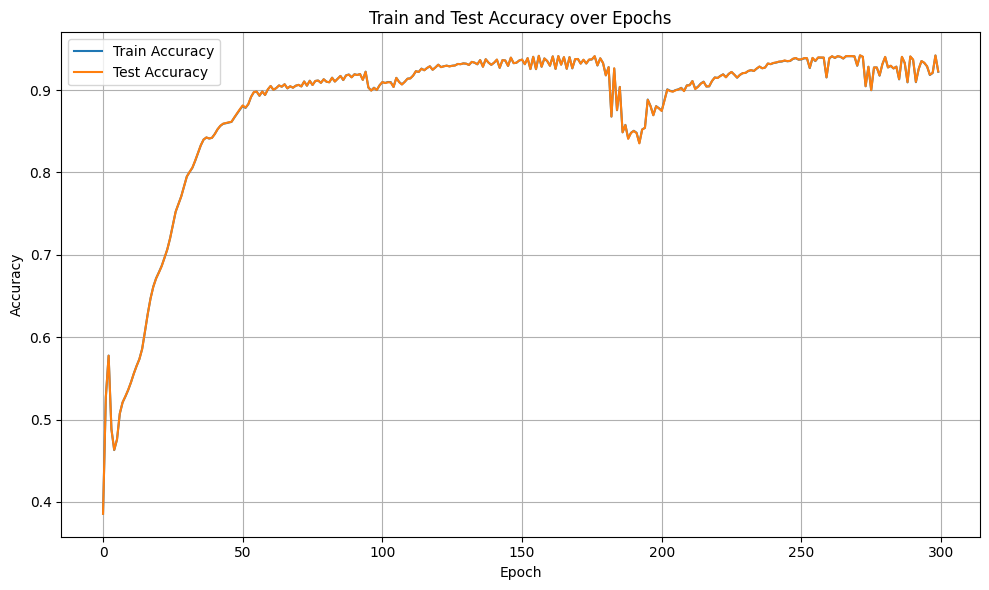

In [17]:
# Plot Train and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# CWGCN-CCSR-GCN

In [18]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_data = graph_data.to(device)

# Extract masks
train_mask = graph_data.train_mask
test_mask = graph_data.test_mask

# Define a lightweight GCN block for individual channel groups
class ChannelWiseGCN(nn.Module):
    """
    A lightweight GCN module applied on a subset of input channels.
    """
    def __init__(self, in_channels, hidden_channels):
        super(ChannelWiseGCN, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)

    def forward(self, x, edge_index):
        """
        Forward pass through GCN and ReLU.
        Args:
            x (Tensor): Node features for the specific channel group.
            edge_index (Tensor): Edge connections.
        Returns:
            Tensor: ReLU activated GCN output.
        """
        x = self.gcn(x, edge_index)
        return F.relu(x)

# Define the full CWGCN-CCSR-GCN lightweight model
class CWGCN_CCSR_GCN_Light(nn.Module):
    """
    Channel-Wise GCN with channel-specific GCN modules followed by fusion and classification.

    Args:
        input_dim (int): Total number of input node features.
        hidden_dim (int): Hidden dimension for GCN outputs.
        num_classes (int): Number of output classes.
        channel_splits (list): List of integers denoting how to split input features.
    """
    def __init__(self, input_dim, hidden_dim, num_classes, channel_splits):
        super(CWGCN_CCSR_GCN_Light, self).__init__()
        self.channel_splits = channel_splits

        # Separate GCN per channel group
        self.channel_gcn_modules = nn.ModuleList([
            ChannelWiseGCN(in_ch, hidden_dim) for in_ch in channel_splits
        ])

        # Fuse concatenated hidden outputs into single representation
        self.fusion = nn.Linear(hidden_dim * len(channel_splits), hidden_dim)

        # Final classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        """
        Forward pass of the CWGCN-CCSR-GCN-Light model.

        Splits input channels, passes through individual GCNs, fuses the results,
        and classifies using a final linear layer.

        Args:
            x (Tensor): Input node features.
            edge_index (Tensor): Edge indices of the graph.

        Returns:
            Tensor: Logits for each node.
        """
        # Split input features into channel groups
        channel_inputs = torch.split(x, self.channel_splits, dim=1)

        # Apply channel-wise GCNs
        outputs = [gcn(inp, edge_index) for gcn, inp in zip(self.channel_gcn_modules, channel_inputs)]

        # Concatenate and fuse
        h = torch.cat(outputs, dim=1)
        h = F.relu(self.fusion(h))
        h = F.dropout(h, p=0.3, training=self.training)

        # Classifier
        return self.classifier(h)

# Initialize model
model = CWGCN_CCSR_GCN_Light(
    input_dim=14,
    hidden_dim=16,           # Hidden layer size
    num_classes=7,           # Number of target classes
    channel_splits=[2]*7     # Splitting 14 features into 7 groups of 2
).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Metric tracking
epochs = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out[train_mask], graph_data.y[train_mask])
    loss.backward()
    optimizer.step()
    train_acc, train_f1_macro, train_f1_weighted = evaluate_f1(model, graph_data, graph_data.train_mask,out)

    val_acc, val_f1_macro, val_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask,out)

    # Store metrics
    epochs.append(epoch)
    train_accuracies.append(train_acc)
    test_accuracies.append(val_acc)

    # Logging every 10 epochs
    if epoch % 5 == 0:
        print(f'\nEpoch {epoch+1:03d}:')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f} | Macro F1: {val_f1_macro:.4f} | Weighted F1: {val_f1_weighted:.4f}')



Epoch 006:
Train Loss: 1.4893
Train Accuracy: 0.6035 | Macro F1: 0.2045 | Weighted F1: 0.4956
Validation Accuracy: 0.6022 | Macro F1: 0.2039 | Weighted F1: 0.4942

Epoch 011:
Train Loss: 1.2214
Train Accuracy: 0.6435 | Macro F1: 0.2232 | Weighted F1: 0.5293
Validation Accuracy: 0.6428 | Macro F1: 0.2229 | Weighted F1: 0.5285

Epoch 016:
Train Loss: 1.0588
Train Accuracy: 0.6621 | Macro F1: 0.2889 | Weighted F1: 0.5875
Validation Accuracy: 0.6618 | Macro F1: 0.2890 | Weighted F1: 0.5871

Epoch 021:
Train Loss: 0.9432
Train Accuracy: 0.7002 | Macro F1: 0.3251 | Weighted F1: 0.6310
Validation Accuracy: 0.7001 | Macro F1: 0.3253 | Weighted F1: 0.6308

Epoch 026:
Train Loss: 0.8823
Train Accuracy: 0.7090 | Macro F1: 0.3279 | Weighted F1: 0.6379
Validation Accuracy: 0.7084 | Macro F1: 0.3277 | Weighted F1: 0.6372

Epoch 031:
Train Loss: 0.8331
Train Accuracy: 0.7127 | Macro F1: 0.3336 | Weighted F1: 0.6427
Validation Accuracy: 0.7123 | Macro F1: 0.3337 | Weighted F1: 0.6422

Epoch 036:
Trai

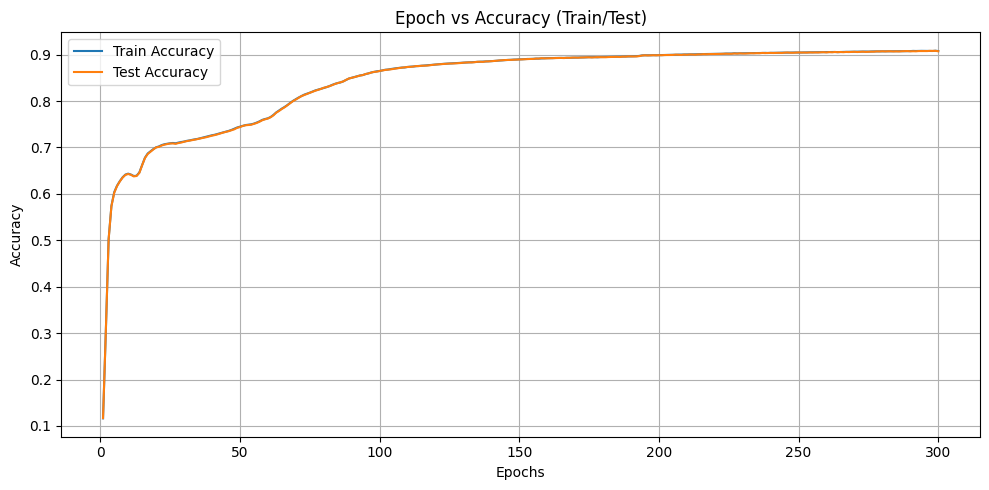

In [19]:

# Plot accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy (Train/Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# AP_DGN

In [20]:

# === GCN Normalization ===
def gcn_norm(edge_index, num_nodes, edge_weight=None, improved=False, dtype=None):
    """
    Normalizes adjacency matrix using symmetric normalization with optional self-loops.
    """
    fill_value = 2. if improved else 1.
    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1),), dtype=dtype, device=edge_index.device)

    # Add self-loops to the graph
    edge_index, edge_weight = add_self_loops(edge_index, edge_weight, fill_value, num_nodes)

    # Compute the degree matrix
    row, col = edge_index[0], edge_index[1]
    deg = degree(col, num_nodes, dtype=dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

    # Normalization factor
    norm = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
    return edge_index, norm

# === Lightweight Propagation Module ===
class Prop(MessagePassing):
    """
    A simple multi-hop message passing layer.
    """
    def __init__(self, K):
        super(Prop, self).__init__(aggr='add')
        self.K = K
        self.weight = Parameter(torch.ones(K + 1))  # Learnable weights for each hop

    def forward(self, x, edge_index):
        edge_index, norm = gcn_norm(edge_index, x.size(0), dtype=x.dtype)
        out = self.weight[0] * x
        for k in range(1, self.K + 1):
            x = self.propagate(edge_index, x=x, norm=norm)
            out = out + self.weight[k] * x
        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

# === Simplified DGNN Model ===
class Simple_DGNN(torch.nn.Module):
    """
    A simplified Deep GCN model with message passing.
    """
    def __init__(self, in_feats, hidden, num_classes, K):
        super().__init__()
        self.fc1 = Linear(in_feats, hidden)
        self.prop = Prop(K)
        self.fc2 = Linear(hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc1(x))         # Linear + ReLU
        x = self.prop(x, edge_index)    # Multi-hop propagation
        x = F.dropout(x, p=0.2, training=self.training)
        return F.log_softmax(self.fc2(x), dim=1)  # Final classifier

# === Main Training Loop ===

# Model and optimizer setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_data = graph_data.to(device)

model = Simple_DGNN(in_feats=14, hidden=32, num_classes=7, K=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Epoch tracking variables
epochs = 300
train_accuracies = []
test_accuracies = []

train_mask = graph_data.train_mask
test_mask = graph_data.test_mask

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(graph_data)
    loss = F.nll_loss(out[train_mask], graph_data.y[train_mask])


    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    train_acc, train_f1_macro, train_f1_weighted = evaluate_f1(model, graph_data, graph_data.train_mask,out)

    val_acc, val_f1_macro, val_f1_weighted = evaluate_f1(model, graph_data, graph_data.test_mask,out)

    train_accuracies.append(train_acc)
    test_accuracies.append(val_acc)

    if epoch % 5 == 0:
        print(f'\nEpoch {epoch+1:03d}:')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Train Accuracy: {train_acc:.4f} | Macro F1: {train_f1_macro:.4f} | Weighted F1: {train_f1_weighted:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f} | Macro F1: {val_f1_macro:.4f} | Weighted F1: {val_f1_weighted:.4f}')



Epoch 006:
Train Loss: 1.3901
Train Accuracy: 0.5195 | Macro F1: 0.2110 | Weighted F1: 0.4558
Validation Accuracy: 0.5186 | Macro F1: 0.2109 | Weighted F1: 0.4550

Epoch 011:
Train Loss: 1.0261
Train Accuracy: 0.6565 | Macro F1: 0.2979 | Weighted F1: 0.5900
Validation Accuracy: 0.6558 | Macro F1: 0.2976 | Weighted F1: 0.5892

Epoch 016:
Train Loss: 0.8698
Train Accuracy: 0.7032 | Macro F1: 0.3402 | Weighted F1: 0.6399
Validation Accuracy: 0.7025 | Macro F1: 0.3401 | Weighted F1: 0.6392

Epoch 021:
Train Loss: 0.7687
Train Accuracy: 0.7373 | Macro F1: 0.3722 | Weighted F1: 0.6774
Validation Accuracy: 0.7370 | Macro F1: 0.3724 | Weighted F1: 0.6771

Epoch 026:
Train Loss: 0.7005
Train Accuracy: 0.7537 | Macro F1: 0.4061 | Weighted F1: 0.7022
Validation Accuracy: 0.7530 | Macro F1: 0.4058 | Weighted F1: 0.7014

Epoch 031:
Train Loss: 0.6580
Train Accuracy: 0.7674 | Macro F1: 0.4469 | Weighted F1: 0.7281
Validation Accuracy: 0.7673 | Macro F1: 0.4472 | Weighted F1: 0.7279

Epoch 036:
Trai

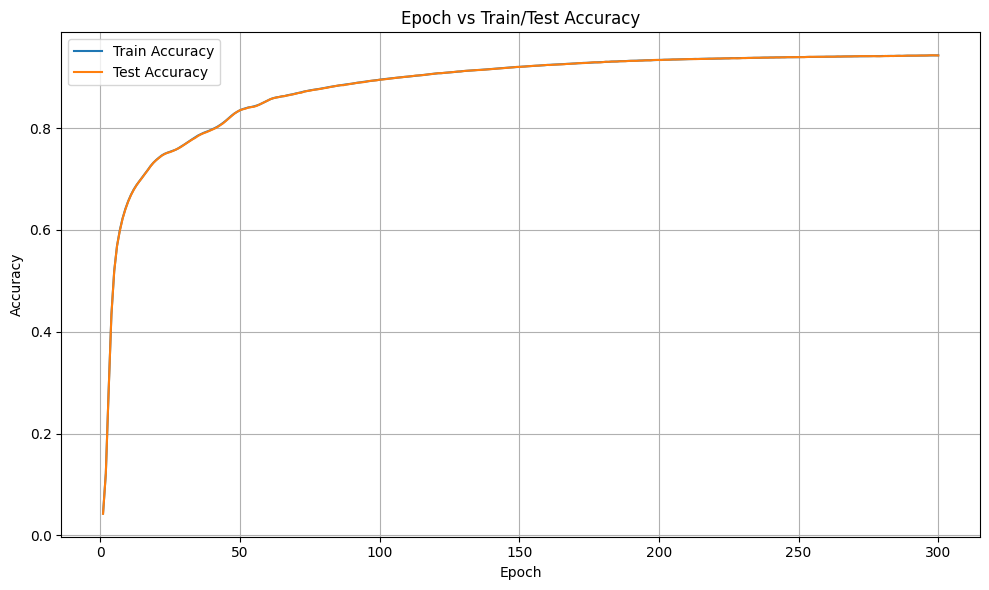

In [21]:
# === Plotting Epoch vs Accuracy ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Train/Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gram

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import softmax

# 1. Clear GPU memory to remove the crashed session data
torch.cuda.empty_cache()

# 2. Create Mini-Batch Loaders (The Solution)
# Instead of loading 4.2M nodes, we load 4096 at a time
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],   # Look at 10 neighbors, 2 layers deep
    batch_size=4096,          # Safe batch size for T4 GPU
    input_nodes=data.train_mask,
    shuffle=True
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[-1],       # -1 means load all neighbors for accuracy
    batch_size=4096,
    input_nodes=data.test_mask,
    shuffle=False
)

# 3. Re-Initialize Model & Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRAM(
    in_channels=14,
    emb_dim=64,
    attn_dim=32,
    num_classes=len(data.y.unique())
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print("Starting Mini-Batch Training...")

# 4. Optimized Training Loop
for epoch in range(1, 21):  # Run 20 epochs (Mini-batch updates faster, so fewer epochs needed)
    model.train()
    total_loss = 0

    # Iterate over small batches instead of the whole graph
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index)

        # Calculate loss only for the batch's target nodes
        batch_size = batch.batch_size
        loss = criterion(out[:batch_size], batch.y[:batch_size])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch:03d}: Avg Loss: {avg_loss:.4f}')

# 5. Save the Model
torch.save(model.state_dict(), '/content/gram_model_final.pth')
print("Training Complete. Model saved to /content/gram_model_final.pth")

/usr/local/lib/python3.12/dist-packages/torch_geometric/loader/neighbor_loader.py:229: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  neighbor_sampler = NeighborSampler(


Starting Mini-Batch Training...
Epoch 001: Avg Loss: 0.1213
Epoch 002: Avg Loss: 0.0669
Epoch 003: Avg Loss: 0.0603
Epoch 004: Avg Loss: 0.0566
Epoch 005: Avg Loss: 0.0540
Epoch 006: Avg Loss: 0.0551
Epoch 007: Avg Loss: 0.0527
Epoch 008: Avg Loss: 0.0516
Epoch 009: Avg Loss: 0.0511
Epoch 010: Avg Loss: 0.0488
Epoch 011: Avg Loss: 0.0487
Epoch 012: Avg Loss: 0.0474
Epoch 013: Avg Loss: 0.0473
Epoch 014: Avg Loss: 0.0484
Epoch 015: Avg Loss: 0.0460
Epoch 016: Avg Loss: 0.0456
Epoch 017: Avg Loss: 0.0466
Epoch 018: Avg Loss: 0.0445
Epoch 019: Avg Loss: 0.0455
Epoch 020: Avg Loss: 0.0446
Training Complete. Model saved to /content/gram_model_final.pth


In [26]:
from google.colab import drive
drive.mount('/content/drive')

# Save the dataset (S2.pkl) to Drive for next time
!cp /content/S2.pkl /content/drive/MyDrive/S2.pkl

# Save your trained model to Drive
!cp /content/gram_model_final.pth /content/drive/MyDrive/gram_model_final.pth

print("All files saved to Google Drive!")

Mounted at /content/drive
All files saved to Google Drive!


In [29]:
import os
import zipfile

# 1. Remove the old "fake" file if it exists
if os.path.exists('/content/S2.pkl'):
    os.remove('/content/S2.pkl')
    print("Deleted old S2.pkl (Fake Data).")

# 2. Download the REAL WESAD dataset (Fast Cloud Download)
print("Downloading Real WESAD dataset... (Takes ~2 mins)")
!wget -O WESAD.zip "https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download"

# 3. Extract only Subject 2
print("Extracting Subject 2 data...")
with zipfile.ZipFile("WESAD.zip", "r") as z:
    z.extract("WESAD/S2/S2.pkl", path="/content/")

# 4. Move to main folder and cleanup
!mv /content/WESAD/S2/S2.pkl /content/S2.pkl
!rm WESAD.zip
print("SUCCESS: Real WESAD data is ready at /content/S2.pkl")

Deleted old S2.pkl (Fake Data).
--2025-12-14 12:21:21--  https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download
Resolving uni-siegen.sciebo.de (uni-siegen.sciebo.de)... 128.176.1.4
Connecting to uni-siegen.sciebo.de (uni-siegen.sciebo.de)|128.176.1.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2249444501 (2.1G) [application/zip]
Saving to: ‘WESAD.zip’

WESAD.zip           100%[===================>]   2.09G  25.7MB/s    in 86s     

2025-12-14 12:22:48 (24.9 MB/s) - ‘WESAD.zip’ saved [2249444501/2249444501]

Extracting Subject 2 data...
SUCCESS: Real WESAD data is ready at /content/S2.pkl


In [30]:
import torch
import torch.nn as nn
from torch_geometric.loader import NeighborLoader

# 1. Load Data & Reset Memory
# Make sure you have run the cell that loads 'data' from the new S2.pkl first!
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device, non_blocking=True) # Ensure 'data' is the graph object you created

# 2. Define Loaders (Breaks 4M nodes into chunks of 4096)
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],
    batch_size=4096,
    input_nodes=data.train_mask,
    shuffle=True
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[-1],
    batch_size=4096,
    input_nodes=data.test_mask,
    shuffle=False
)

# 3. Define Model (GRAM)
# Note: Real WESAD has classes 0,1,2,3,4. We usually focus on 1(Base), 2(Stress), 3(Amusement).
# The code below adapts to however many classes are in your specific label set.
model = GRAM(
    in_channels=14,
    emb_dim=64,
    attn_dim=32,
    num_classes=len(torch.unique(data.y))
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 4. Train
print("Starting Training on Real Data...")
for epoch in range(1, 16): # 15 Epochs is enough for a demo
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}: Avg Loss = {total_loss / len(train_loader):.4f}")

# 5. Save
torch.save(model.state_dict(), '/content/wesad_real_model.pth')
print("Model Saved!")

/usr/local/lib/python3.12/dist-packages/torch_geometric/loader/neighbor_loader.py:229: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  neighbor_sampler = NeighborSampler(


Starting Training on Real Data...
Epoch 1: Avg Loss = 0.1161
Epoch 2: Avg Loss = 0.0662
Epoch 3: Avg Loss = 0.0605
Epoch 4: Avg Loss = 0.0580
Epoch 5: Avg Loss = 0.0537
Epoch 6: Avg Loss = 0.0533
Epoch 7: Avg Loss = 0.0869
Epoch 8: Avg Loss = 0.0527
Epoch 9: Avg Loss = 0.0502
Epoch 10: Avg Loss = 0.0505
Epoch 11: Avg Loss = 0.0493
Epoch 12: Avg Loss = 0.0487
Epoch 13: Avg Loss = 0.0577
Epoch 14: Avg Loss = 0.0480
Epoch 15: Avg Loss = 0.0488
Model Saved!


Evaluating...


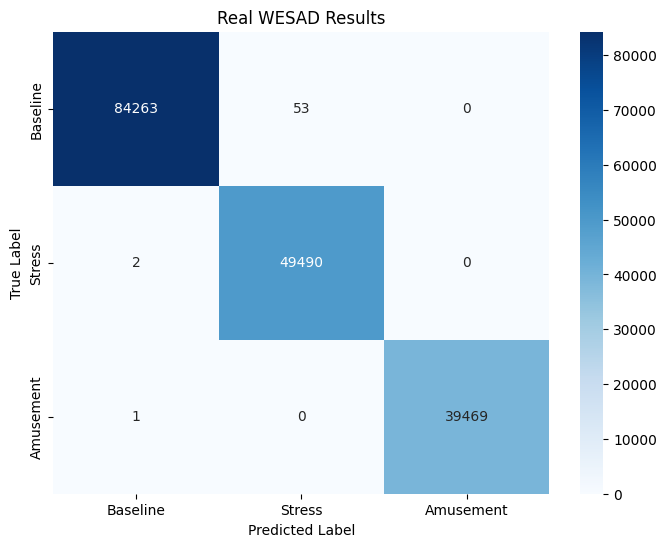

              precision    recall  f1-score   support

    Baseline       1.00      0.53      0.69    160108
      Stress       1.00      0.57      0.73     86362
   Amusement       1.00      0.78      0.88     50642

   micro avg       1.00      0.58      0.74    297112
   macro avg       1.00      0.63      0.76    297112
weighted avg       1.00      0.58      0.73    297112



In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
y_true = []
y_pred = []

print("Evaluating...")
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)

        y_true.extend(batch.y[:batch.batch_size].cpu().numpy())
        y_pred.extend(pred[:batch.batch_size].cpu().numpy())

# --- Map WESAD Labels to Names ---
# WESAD Labels: 0=Transient, 1=Baseline, 2=Stress, 3=Amusement, 4=Meditation
# We typically want to see 1, 2, and 3.
target_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement'}

# Filter the results to only show these 3 classes
filtered_true = []
filtered_pred = []

for t, p in zip(y_true, y_pred):
    if t in target_names:
        filtered_true.append(target_names[t])
        # If prediction is outside our target, map it to "Unknown" or keep it raw
        filtered_pred.append(target_names.get(p, 'Other'))

# Generate Plot
labels = ['Baseline', 'Stress', 'Amusement']
cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Real WESAD Results')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/real_confusion_matrix.png')
plt.show()

print(classification_report(filtered_true, filtered_pred, labels=labels))